<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

#XAI-related packages: LIME and SHAP
import lime 
import lime.lime_tabular
import shap 
import shap.plots

C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [3]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None
length=10
spacing=1
folderpath='../Features'

for filename in os.listdir(folderpath):   
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

#All scenario correlated ONLY TO "length" and "spacing" variables
print(X)
print(y)
print(X.shape)
print(y.shape)

# Features scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X)
print(y)
print(X.shape)
print(y.shape)



Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [4]:
############################################################################################################
###### Perform XGBoost hyperparameters optimization via crossvalidation
###### Print hyperparameters obtained with crossvalidation in resfileXGB
###### Retrain an XGB model with best hyperparameters using the entire training set (X_train, y_train)
###### Print training results (best accuracy and training duration) in resfileXGB
###### Return the trained XGB model
###### for XGB with given hyperparameters space 
###### XGB documentation at: https://xgboost.readthedocs.io/en/stable/python/python_intro.html 
###### XGB hyperparameters: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html 
############################################################################################################

def train_classifier_XGB(X_train, y_train, resfileXGB): 

    #F: define the search space for your hyperparameters - a space where to search
    # These parameters are needed to balance between underfitting and overfitting
    # We are testing 3 hyperparameters: eta, max_depth and subsample
    space4xgb = { 
     'eta': hp.choice('eta', [0.1, 0.3, 0.5, 0.7, 0.9, 1]),
     # max_depth (maximum depth of the decision trees being trained)
     'max_depth': hp.choice('max_depth', np.arange(1, 20, 2)),
     'subsample': hp.choice('subsample', [0.1, 0.3, 0.5, 0.7, 0.9, 1])
    }

    # hyperopt is used to perform an efficent search in the space of parameters
    def hyperopt_train_test(params):
        model = XGBClassifier(verbosity = 0, **params)
        #F: see https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
        
        return cross_val_score(model, X_train, y_train, cv = 5).mean()
        #F: cross_val_score is from scikit learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        #F: will use the default score (for XGB it is accuracy)
        #F: this includes also training; cv=5 (5 number of folds) (5-folds crossvalidation)
        #F: .mean() is taken as cross_val_score returns an array of scores (one for each fold)
        # We have to do the mean because "cross_val_score" returns the accuracy of all the folds

    #We pass to this function the "space4xgb" parameter (in fmin() function)
    #F: this function is used below, as a parameter to fmin
    def f(params): 
        # assumes that "hyperopt_train_test" gives use the best cross validation accuracy 
        # given that combination of hyperparameters (params)
        acc = hyperopt_train_test(params)
        #F: loss is returned as opposite (negative) of accuracy because we will use in 
        #f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)
        # We need to return these parameters because fmin() requires them
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    trials = Trials()
    # best_params stores the index of the best parameters values according to the function
    # fmin() returns the indexes based on the minimum value of a passed function "f"
    # space4xgb is the search space
    # algo=tpe.suggest is the used alorithm
    # max_evals=5 is the maximum trials
    best_params = fmin(f, space4xgb, algo=tpe.suggest, max_evals=5, trials=trials)
    #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
    #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4xgb
    print(best_params)
    
    #Insert in the paramets the values of the hyperparameters (not the indexes)
    best_params = hyperopt.space_eval(space4xgb, best_params)
    #F: this is used to extract from space4xgb the best values according to the indexes in best_params (and put such values in best_params)
    print(best_params)
    
    best_cv_acc = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
    print('best_cv_acc: ' + str(best_cv_acc))

    xgb = XGBClassifier(eta = best_params['eta'], max_depth= best_params['max_depth'], 
                            subsample = best_params['subsample'], verbosity = 0) 

    t0 = time.time()
    #F: fit() is a function from scikit learn interface for XGB (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#scikit-learn-interface), 
    # there is also train() that can be used directly with XGB objects (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training) 
    xgb.fit(X_train, y_train) 
    t1 = time.time()

    with open(resfileXGB, 'w') as result_file:
        result_file.write('Best eta: {}\n'.format(best_params['eta']))
        result_file.write('Best max depth: {}\n'.format(best_params['max_depth']))
        result_file.write('Best subsample: {}\n'.format(best_params['subsample']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
        result_file.write('Training duration for XGB is {} s\n'.format(round(t1 - t0)))

    return xgb


In [5]:
############################################################################################################
###### Perform DNN hyperparameters optimization via crossvalidation
###### Print hyperparameters obtained with crossvalidation in resfileDNN
###### Retrain a DNN model with best hyperparameters using the entire training set (X_train, y_train)
###### Print training results (best accuracy and training duration) in resfileDNN
###### Return the trained DNN model
############################################################################################################

def train_classifier_DNN(X_train, y_train, resfileDNN): 

    #F: define the search space for your hyperparameters
    space4dnn = {
     'activation': hp.choice('activation', ['logistic', 'tanh', 'relu']),
     'neurons': hp.choice('neurons', [10, 50, 100]),
     'layers': hp.choice('layers', np.arange(1, 4, 1))
    }

    def hyperopt_train_test(params):
        size = (params['neurons'],) * params['layers']
        dnn = MLPClassifier(hidden_layer_sizes=size, activation=params['activation'],
                            solver='adam', learning_rate='invscaling', max_iter=1000)
        return cross_val_score(dnn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    trials = Trials()
    best_params = fmin(f, space4dnn, algo=tpe.suggest, max_evals=5, trials=trials)
    print(best_params) 
    
    best_params = hyperopt.space_eval(space4dnn, best_params)
    print(best_params) 
    
    best_cv_acc = -round(trials.best_trial['result']['loss'], 2)
    print('best_cv_acc: ' + str(best_cv_acc))
    
    
    size = (best_params['neurons'],) * best_params['layers']
    dnn = MLPClassifier(hidden_layer_sizes=size, activation=best_params['activation'],
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    t0 = time.time()
    dnn.fit(X_train, y_train)
    t1 = time.time()

    with open(resfileDNN, 'w') as result_file:
        result_file.write('Best number of layers: {}\n'.format(best_params['layers']))
        result_file.write('Best number of neurons: {}\n'.format(best_params['neurons']))
        result_file.write('Best activation function: {}\n'.format(best_params['activation']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
        result_file.write('Training duration for DNN is {} s\n'.format(round(t1 - t0)))

    return dnn


In [6]:
############################################################################################################
###### Perform KNN hyperparameters optimization via crossvalidation
###### Print hyperparameters obtained with crossvalidation in resfileKNN
###### Retrain a KNN model with best hyperparameters using the entire training set (X_train, y_train)
###### Print training results (best accuracy and training duration) in resfileKNN
###### Return the trained KNN model
############################################################################################################

def train_classifier_KNN(X_train, y_train, resfileKNN): 

    #F: define the search space for your hyperparameters
    space4knn = {
     'leaf_size': hp.choice('leaf_size', np.arange(1, 50, 1)),
     'p': hp.choice('p', [1, 2]),
     'n_neighbors': hp.choice('n_neighbors', np.arange(1, 30, 1))
    }

    def hyperopt_train_test(params):
        knn = KNeighborsClassifier(leaf_size=params['leaf_size'], p=params['p'], 
                                   n_neighbors=params['n_neighbors'])
        return cross_val_score(knn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    trials = Trials()
    best_params = fmin(f, space4knn, algo=tpe.suggest, max_evals=5, trials=trials)
    print(best_params) 
    
    best_params = hyperopt.space_eval(space4knn, best_params)
    print(best_params) 
    
    best_cv_acc = -round(trials.best_trial['result']['loss'], 2)
    print('best_cv_acc: ' + str(best_cv_acc))
    
    knn = KNeighborsClassifier(leaf_size=best_params['leaf_size'], p=best_params['p'], 
                                   n_neighbors=best_params['n_neighbors'])

    t0 = time.time()
    knn.fit(X_train, y_train)
    t1 = time.time()

    with open(resfileKNN, 'w') as result_file:
        result_file.write('Best leaf_size: {}\n'.format(best_params['leaf_size']))
        result_file.write('Best number of p: {}\n'.format(best_params['p']))
        result_file.write('Best number of neighbors: {}\n'.format(best_params['n_neighbors']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
        result_file.write('Training duration for kNN is {} s\n'.format(round(t1 - t0)))

    return knn


In [7]:
################################################################################################################
###### Split into into train/test and call train_classifier_XXX() functions
################################################################################################################
res_folder = '1_1_Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

resfile_XGB=res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'
resfile_DNN=res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'
resfile_KNN=res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'

# Stratify garantees the split all the scenarios among train and test
# It's like shuffle and split
# random_state it's a seed to get the same output
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(y_test)
print(X_test)


print('Training XGB...')
xgb = train_classifier_XGB(X_train, y_train, resfile_XGB)

print('Training DNN...')
dnn = train_classifier_DNN(X_train, y_train, resfile_DNN)

print('Training KNN...')
knn = train_classifier_KNN(X_train, y_train, resfile_KNN)

[0 0 0 ... 0 0 0]
[[-0.07903669 -0.07905794 -0.53654565 -0.31595749 -0.08354188 -0.07399217]
 [ 0.31163765  0.31161641 -0.80095167 -1.0687397   0.30754744  0.32255547]
 [-0.07279471 -0.07281596  0.70412873  0.56228842 -0.05859435 -0.07141957]
 ...
 [-1.19341323 -1.19343447 -0.86196844 -0.62961674 -1.19627541 -1.18278198]
 [ 0.32595748  0.32593624 -0.4958678  -0.50415304  0.31378433  0.32329049]
 [-0.03571003 -0.03573127  0.74480657  0.56228842 -0.0277768  -0.04128342]]
Training XGB...
100%|██████████| 5/5 [04:09<00:00, 49.93s/trial, best loss: -0.9993073528805491]
{'eta': 3, 'max_depth': 2, 'subsample': 4}
{'eta': 0.7, 'max_depth': 5, 'subsample': 0.9}
best_cv_acc: 1.0
Training DNN...
100%|██████████| 5/5 [27:13<00:00, 326.63s/trial, best loss: -0.9983998567715906]
{'activation': 2, 'layers': 0, 'neurons': 2}
{'activation': 'relu', 'layers': 1, 'neurons': 100}
best_cv_acc: 1.0
Training KNN...
100%|██████████| 5/5 [01:22<00:00, 16.45s/trial, best loss: -0.9977937908698383]
{'leaf_size':

In [8]:
# Define model names
xgbmodelfile = res_folder + '/XGB_sp{}_w{}.json'.format(spacing, length) 
dnnmodelfile = res_folder + '/DNN_sp{}_w{}.json'.format(spacing, length)
knnmodelfile = res_folder + '/KNN_sp{}_w{}.json'.format(spacing, length)

In [9]:
# Save the models to disk
xgb.save_model(xgbmodelfile)
pickle.dump(dnn, open(dnnmodelfile, 'wb'))
pickle.dump(knn, open(knnmodelfile, 'wb'))

max_depth is not saved in Scikit-Learn meta.


In [10]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names, resfile):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #F: normalized wrt true labels (axis=1 sums the elements of one row and sums them; this is done for all the rows independently)

    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write('Accuracy: {}\n'.format(accuracy))
        result_file.write('Precision per class: {}\n'.format(precision))
        result_file.write('Global Precision: {}\n'.format(global_precision))
        result_file.write('Recall per class: {}\n'.format(recall))
        result_file.write('Global Recall: {}\n'.format(global_recall))
        result_file.write('F1-score: {}\n'.format(f1score))
        result_file.write('Global F1-score: {}\n'.format(global_f1score))
        
        result_file.write('\nConfusion matrix, without normalization\n')
        np.savetxt(result_file, cm, fmt = '%.2f')

        result_file.write('\nNormalized confusion matrix\n')
        #np.savetxt(result_file, cm_norm, fmt = '%.2f')
        result_file.write(str(cm_norm))

    return accuracy, global_precision, global_recall, global_f1score 


In [19]:
##############################################################################################################
###### Load models into NEW models, perform prediction and evaluate performance using performance_eval() 
##############################################################################################################

restestfileXGB = res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
restestfileDNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
restestfileKNN = res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'

# load the model from disk
loaded_xgb = XGBClassifier()
loaded_xgb.load_model(xgbmodelfile)

# load the model from disk
loaded_dnn = pickle.load(open(dnnmodelfile, 'rb'))

# load the model from disk
loaded_knn = pickle.load(open(knnmodelfile, 'rb'))

lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

# Added to fix: 'XGBClassifier' object has no attribute '_le'
loaded_xgb._le = LabelEncoder().fit(y_test)

y_pred_XGB = loaded_xgb.predict(X_test)
y_pred_DNN = loaded_dnn.predict(X_test)
y_pred_KNN = loaded_knn.predict(X_test)

XGB_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
DNN_metrics = performance_eval(y_test, y_pred_DNN, lbl, label_names, restestfileDNN)
KNN_metrics = performance_eval(y_test, y_pred_KNN, lbl, label_names, restestfileKNN)

print('XGB metrics: ' +str(XGB_metrics))
print('****************')
print('DNN metrics: ' +str(DNN_metrics))
print('****************')
print('KNN metrics: ' +str(KNN_metrics))

XGB metrics: (0.9991919140093892, 0.9991919157094731, 0.9991919140093892, 0.9991918335272918)
****************
DNN metrics: (0.9983710012570226, 0.9983718360003401, 0.9983710012570226, 0.9983704358534956)
****************
KNN metrics: (0.9980503322131294, 0.9980530097616327, 0.9980503322131294, 0.9980492733474065)


In [20]:
####################################################
###### Task 2a) Initialize the LIME explainer ######
####################################################
############# CODE ALREADY GIVEN BELOW #############

#get names of features (columns from data set) and set class names 
f = ['mean', 'RMS', 'ptp', 'std', 'max', 'min']

#create LIME tabular explainer with 4 arguments: 
# 1) train data X_train that will be used to fit the blackbox model
# 2) features' names f (for visualization purposes)
# 3) name of classes (for visualization purposes)
# 4) mode (classification or regression, we are dealing with a classification problem)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=f, class_names=label_names, mode='classification')


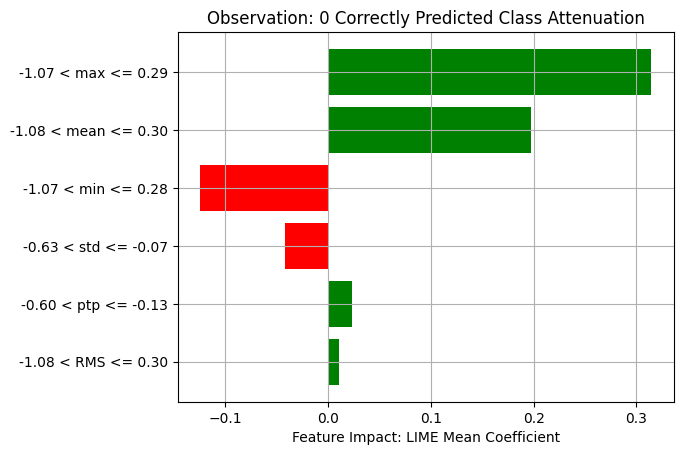

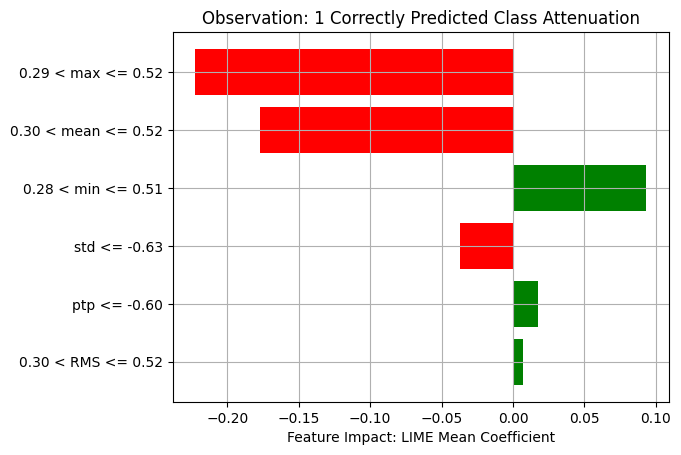

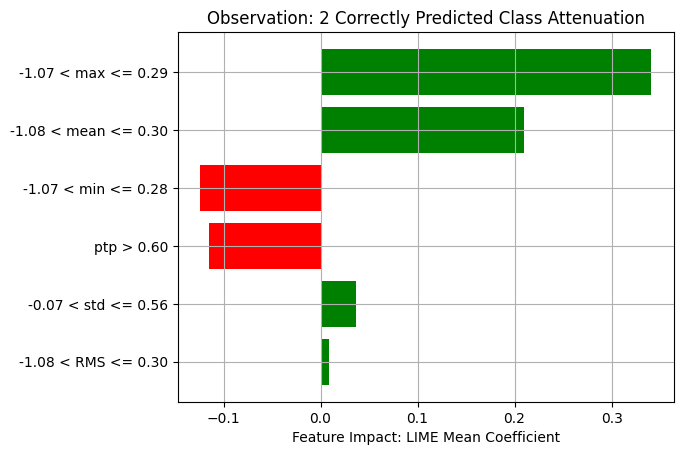

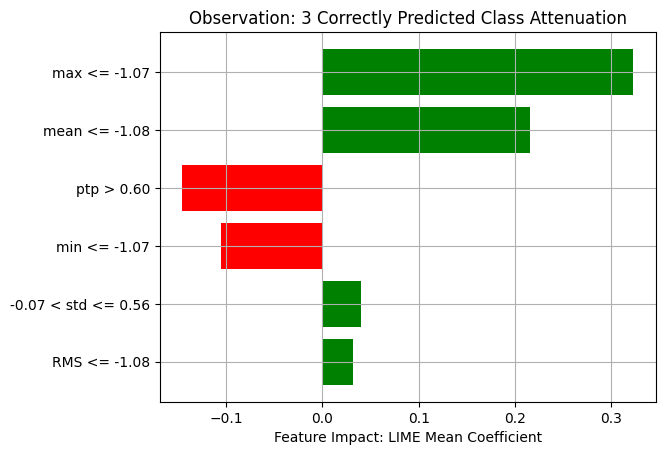

In [28]:
###########################################################################
###### Task 2b) Perform local explanations for some test data points ######
###########################################################################

#to perform local explanations, we will use the method 'explain_instance'. 
#explain_instance takes 4 arguments: 
    # 1) data point to explain X_test[n], 
    # 2) blackbox model prediction function rf.predict_proba
    # 3) number of features to visualize in the output figure 
    # 4) set of labels (we will define a labels array for this purpose)


# 1) for a given value of n, X_test[n] represents the test point to explain and the 1st argument to pass to explain_instance
# 2) rf.predict_proba represents the second argument to pass to explain_instance
# 3) num_features=15 to visualize on output figure the most important 15 features, this is the 3rd argument to pass to explain_instance
labels  = [0, 1] # 4) 4th argument to pass to explain_instance


N = 4 #number of test data points to explain

# Let's explain 2 points in the test set:   
for n in range(N):   
    exp = explainer.explain_instance(X_test[n], loaded_xgb.predict_proba, num_features=15, labels=lbl) 
    #exp now represents the explanation of test data point X_test[n]
    
    #draw exp as a pyplot figure. Pass exp.as_pyplot_figure the predicted class
    exp.as_pyplot_figure(int(y_pred_XGB[n])) 

    #check if correct or wrong prediction and set appropriate plot title (using 'blackboxprediction' variable)
    if int(y_test[n]) == int(y_pred_XGB[n]):
        blackboxprediction = 'Correctly Predicted Class %s' % exp.class_names[int(y_pred_XGB[n])]
    else: 
        blackboxprediction = 'Wrongly Predicted Class %s' % exp.class_names[int(y_pred_XGB[n])]        
    #set a title to figure
    title = "Observation: " + str(n) + ' ' + blackboxprediction 
    plt.title(title) 
    #set x-axis label and plot figure
    plt.xlabel('Feature Impact: LIME Mean Coefficient')
    plt.grid()
    plt.show()

    
#Now you should explain 3 data points in the test set that have been misclassified by the rf model
############# ADD YOUR CODE BELOW #############







In [26]:
######################################################################################
###### Task 3a) Initialize the SHAP explainer and calculate/show SHAP values #########
######################################################################################
############# CODE ALREADY GIVEN BELOW #############


#set number of shap points to consider with SHAP, we can consider the whole dataset 
shappoints = 2500

#create and initialize explainer, we use TreeExplainer and pass the rf classifier as an argument
explainer_shap = shap.TreeExplainer(loaded_xgb)

#Calculating the SHAP values by using shap_values method. It takes training data as an argument
shap_values = explainer_shap.shap_values(X[:shappoints])

shap_values

array([[-5.166069  ,  1.0233593 , -0.3273974 , -2.0294023 , -7.0988183 ,
         2.2081873 ],
       [-5.166069  ,  1.0233593 , -0.3273974 , -2.0294023 , -7.0988183 ,
         2.2081873 ],
       [-5.555308  ,  0.99684477, -0.04333099, -1.5079739 , -6.9145555 ,
         2.319561  ],
       ...,
       [-4.99567   ,  1.1297591 , -0.58105093,  1.4783951 , -7.11347   ,
         2.153744  ],
       [-4.99567   ,  1.1297591 , -0.58105093,  1.4783951 , -7.11347   ,
         2.153744  ],
       [-4.99567   ,  1.1297591 , -0.58105093,  1.4783951 , -7.11347   ,
         2.153744  ]], dtype=float32)

In [27]:
#####################################################################
###### Task 3b) Plot SHAP Summary Plot for each of the classes ######
#####################################################################
############# CODE ALREADY GIVEN BELOW #############


#Iterate over labels (classes) and plot SHAP's summary plot of each label using shap.summary_plot method
#method takes shap_values of the class, data set (from this SHAP gets features' values) and features names 
#in addition to the number of features to display
#we use show = False so the figure is not directly plotted so we can add a unique title to it in a next step
for classitr in range(len(set(y))):
    shap.summary_plot(shap_values[classitr], features=X[:shappoints],feature_names=f, show = False, max_display=18)
    #set title and show
    title = 'Summary Plot for ' + str(label_names[classitr])
    plt.title(title)
    plt.show()


AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [ ]:
#######################################################################################
###### Task 3c) Plot SHAP Globe Summary Plot ##########################################
#######################################################################################
############# CODE ALREADY GIVEN BELOW #############

#Plot the overall summary plot (for all classes) using summary_plot method
#We passed the method 4 arguments: 1) calculated SHAP values, 2) feature names, 3) show = False to not directly
#plot the figure and 4) max_display to specify the number of features to display in figure
shap.summary_plot(shap_values, feature_names=f, show = False, max_display=18)
plt.title("Summary Plot")
plt.show()
